In [1]:
import cv2
import mediapipe as mp
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

Extracting keypoints

In [2]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def extract_keypoints(video_path):
    cap = cv2.VideoCapture(video_path)
    hands = mp_hands.Hands()
    keypoints = []

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        # Flip the image horizontally for a later selfie-view display
        frame = cv2.flip(frame, 1)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                frame_keypoints = []
                for lm in hand_landmarks.landmark:
                    frame_keypoints.extend([lm.x, lm.y, lm.z])
                keypoints.append(frame_keypoints)

                # Draw hand landmarks on the frame
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        # Display the frame
        cv2.imshow('Hand Tracking', frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    hands.close()
    return keypoints

def save_keypoints_to_csv(keypoints, csv_path):
    df = pd.DataFrame(keypoints)
    df.to_csv(csv_path, index=False)

# # Example usage
# video_path = 'path_to_your_video.mp4'
# keypoints = extract_keypoints(video_path)
# csv_path = video_path.replace('.mp4', '.csv')
# save_keypoints_to_csv(keypoints, csv_path)
# print(f"Saved keypoints for {video_path} to {csv_path}")

In [3]:
def load_dataset(dataset_path):
    video_paths = []
    labels = []

    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if os.path.isdir(label_path):
            for video_id in os.listdir(label_path):
                video_folder = os.path.join(label_path, video_id)
                if os.path.isdir(video_folder):
                    for root, _, files in os.walk(video_folder):
                        for file in files:
                            if file.endswith('.mp4'):
                                video_path = os.path.join(root, file)
                                video_paths.append(video_path)
                                labels.append(label)
    
    return video_paths, labels

# Example usage
dataset_path = './augmented_3asharat'
video_paths, labels = load_dataset(dataset_path)

for video_path in video_paths:
    keypoints = extract_keypoints(video_path)
    csv_path = video_path.replace('.mp4', '.csv')
    save_keypoints_to_csv(keypoints, csv_path)
    print(f"Saved keypoints for {video_path} to {csv_path}")

In [4]:
def preprocess_keypoints(csv_path, max_sequence_length):
    df = pd.read_csv(csv_path)
    if df.empty:
        raise ValueError(f"No keypoints found in {csv_path}")
    
    keypoints = df.values
    keypoints = keypoints / np.max(np.abs(keypoints), axis=0)

    if len(keypoints) < max_sequence_length:
        padding = np.zeros((max_sequence_length - len(keypoints), keypoints.shape[1]))
        keypoints = np.vstack((keypoints, padding))
    else:
        keypoints = keypoints[:max_sequence_length, :]
    
    return keypoints

def preprocess_labels(labels):
    if not labels:
        raise ValueError("Labels list is empty")
    
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)
    labels_categorical = to_categorical(labels_encoded)
    # Save the classes
    np.save('classes.npy', le.classes_)
    return labels_categorical, le

# Example usage
max_sequence_length = 100
keypoint_sequences = []
for video_path in video_paths:
    csv_path = video_path.replace('.mp4', '.csv')
    keypoints = preprocess_keypoints(csv_path, max_sequence_length)
    keypoint_sequences.append(keypoints)

keypoint_sequences = np.array(keypoint_sequences)
print(f"Preprocessed keypoint sequences shape: {keypoint_sequences.shape}")

labels_categorical, label_encoder = preprocess_labels(labels)
print(f"Encoded labels: {labels_categorical.shape}")

Preprocessed keypoint sequences shape: (1800, 100, 63)
Encoded labels: (1800, 20)


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(keypoint_sequences, labels_categorical, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}, {y_train.shape}")
print(f"Validation set size: {X_val.shape}, {y_val.shape}")

Training set size: (1440, 100, 63), (1440, 20)
Validation set size: (360, 100, 63), (360, 20)


In [2]:
from tensorflow.keras.layers import Layer, Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf

class CustomAttention(Layer):
    def __init__(self, **kwargs):
        super(CustomAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[-1],),
                                 initializer='zeros', trainable=True)
        super(CustomAttention, self).build(input_shape)

    def call(self, inputs, **kwargs):
        scores = K.tanh(K.dot(inputs, self.W) + self.b)
        weights = K.softmax(scores, axis=1)
        context_vector = weights * inputs
        context_vector = K.sum(context_vector, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional,BatchNormalization,Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model

def create_lstm_model_with_custom_attention(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = LSTM(128, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    attention = CustomAttention()(x)

    x = Dense(128, activation='relu')(attention)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


input_shape = (max_sequence_length, 63)  # 21 keypoints * 3 (x, y, z)
num_classes = labels_categorical.shape[1]
model = create_lstm_model_with_custom_attention(input_shape, num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 63)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 128)          98304     
                                                                 
 batch_normalization_2 (Bat  (None, 100, 128)          512       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 128)          131584    
                                                                 
 batch_normalization_3 (Bat  (None, 100, 128)          512       
 chNormalization)                                          

In [18]:
history = model.fit(X_train, y_train, epochs=350, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/350
45/45 [==============================] - 21s 334ms/step - loss: 2.2775 - accuracy: 0.3035 - val_loss: 2.8468 - val_accuracy: 0.1222 - lr: 0.0010
Epoch 2/350
45/45 [==============================] - 12s 264ms/step - loss: 1.4295 - accuracy: 0.5306 - val_loss: 2.6198 - val_accuracy: 0.2611 - lr: 0.0010
Epoch 3/350
45/45 [==============================] - 11s 247ms/step - loss: 1.1052 - accuracy: 0.6340 - val_loss: 2.4164 - val_accuracy: 0.3083 - lr: 0.0010
Epoch 4/350
45/45 [==============================] - 11s 245ms/step - loss: 0.9159 - accuracy: 0.6875 - val_loss: 2.2352 - val_accuracy: 0.2389 - lr: 0.0010
Epoch 5/350
45/45 [==============================] - 11s 240ms/step - loss: 0.6763 - accuracy: 0.7799 - val_loss: 1.8524 - val_accuracy: 0.3833 - lr: 0.0010
Epoch 6/350
45/45 [==============================] - 11s 242ms/step - loss: 0.5883 - accuracy: 0.8083 - val_loss: 1.4908 - val_accuracy: 0.5306 - lr: 0.0010
Epoch 7/350
45/45 [==============================] - 10s 2

In [54]:
# Assuming you have your training history in the `history` variable

# Print the final training accuracy and loss
final_training_accuracy = history.history['accuracy'][-1]
final_training_loss = history.history['loss'][-1]
print(f"Training Accuracy: {final_training_accuracy:.4f}")
print(f"Training Loss: {final_training_loss:.4f}")

# Print the final validation accuracy and loss
final_validation_accuracy = history.history['val_accuracy'][-1]
final_validation_loss = history.history['val_loss'][-1]
print(f"Validation Accuracy: {final_validation_accuracy:.4f}")
print(f"Validation Loss: {final_validation_loss:.4f}")

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy from evaluation: {val_accuracy:.4f}")
print(f"Validation Loss from evaluation: {val_loss:.4f}")


Training Accuracy: 0.9979
Training Loss: 0.0046
Validation Accuracy: 0.9583
Validation Loss: 0.1459
12/12 [==============================] - 2s 55ms/step - loss: 0.0993 - accuracy: 0.9750
Validation Accuracy from evaluation: 0.9750
Validation Loss from evaluation: 0.0993


Graphs

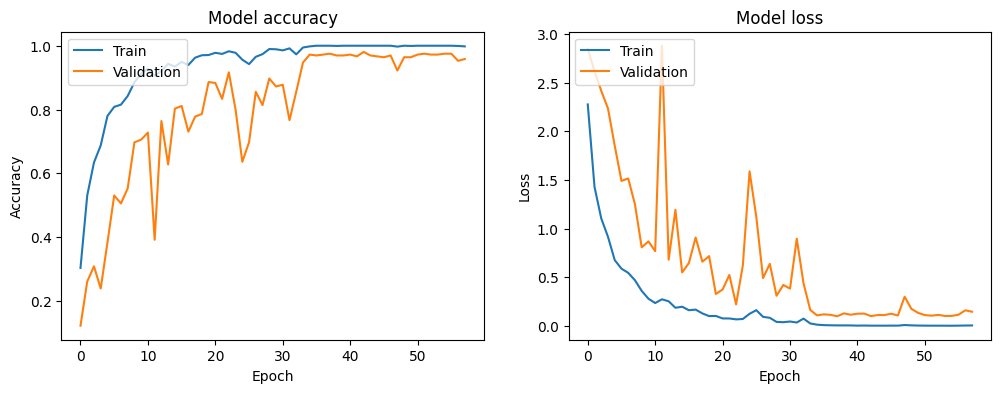

12/12 [==============================] - 1s 50ms/step


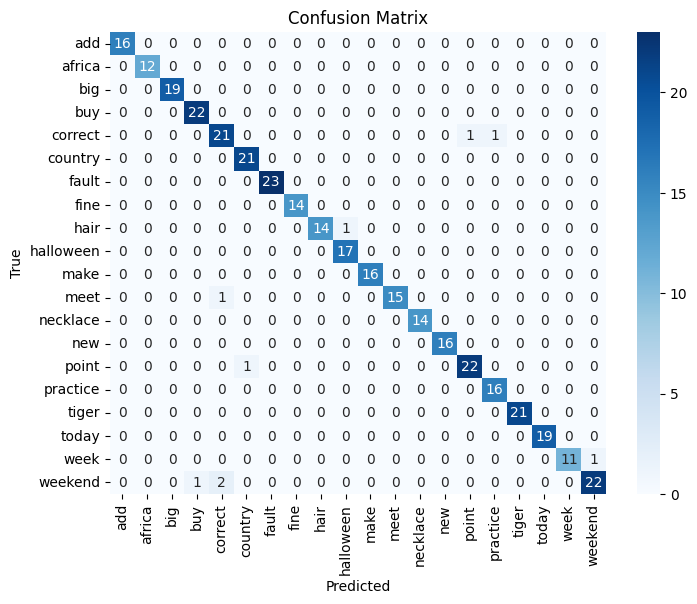

              precision    recall  f1-score   support

         add       1.00      1.00      1.00        16
      africa       1.00      1.00      1.00        12
         big       1.00      1.00      1.00        19
         buy       0.96      1.00      0.98        22
     correct       0.88      0.91      0.89        23
     country       0.95      1.00      0.98        21
       fault       1.00      1.00      1.00        23
        fine       1.00      1.00      1.00        14
        hair       1.00      0.93      0.97        15
   halloween       0.94      1.00      0.97        17
        make       1.00      1.00      1.00        16
        meet       1.00      0.94      0.97        16
    necklace       1.00      1.00      1.00        14
         new       1.00      1.00      1.00        16
       point       0.96      0.96      0.96        23
    practice       0.94      1.00      0.97        16
       tiger       1.00      1.00      1.00        21
       today       1.00    

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Assuming `history` is the training history object from model training
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Assuming you have your test data prepared as X_test and y_test
# Here we use placeholder data, replace it with your actual data
# X_test should be of shape (num_samples, 100, 63) to match the model input
# y_test should be the corresponding labels in one-hot encoded format

# Predict the classes
y_pred = np.argmax(model.predict(X_val), axis=-1)
y_true = np.argmax(y_val, axis=-1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print(report)


In [37]:
model.save('sign_language_with_attention.h5')
print("Model with attention saved as sign_language_with_attention.h5")

Model with attention saved as sign_language_with_attention.h5


c:\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from tensorflow.keras.utils import custom_object_scope

# Ensure the custom layer is registered when loading the model
with custom_object_scope({'CustomAttention': CustomAttention}):
    model = load_model('sign_language_with_attention.h5')

# Load the label encoder classes
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('classes.npy', allow_pickle=True)

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

max_sequence_length = 100

def extract_keypoints_from_frame(frame, hands):
    keypoints = []
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            frame_keypoints = []
            for lm in hand_landmarks.landmark:
                frame_keypoints.extend([lm.x, lm.y, lm.z])
            keypoints.append(frame_keypoints)

    return keypoints

def preprocess_keypoints(keypoints, max_sequence_length):
    keypoints = np.array(keypoints)
    keypoints = keypoints / np.max(np.abs(keypoints), axis=0)

    if len(keypoints) < max_sequence_length:
        padding = np.zeros((max_sequence_length - len(keypoints), keypoints.shape[1]))
        keypoints = np.vstack((keypoints, padding))
    else:
        keypoints = keypoints[:max_sequence_length, :]

    return keypoints

# Initialize MediaPipe Hands
hands = mp_hands.Hands()

# Function to process a video file
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file {video_path}")
        return

    all_keypoints = []

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        # Flip the image horizontally for a later selfie-view display
        frame = cv2.flip(frame, 1)

        # Extract keypoints from the frame
        keypoints = extract_keypoints_from_frame(frame, hands)

        if keypoints:
            all_keypoints.extend(keypoints)

        # Display hand landmarks on the frame
        results = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        # Display the frame
        cv2.imshow('Hand Tracking', frame)

        # Exit on 'q' key press
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # Preprocess the accumulated keypoints and make a prediction
    if all_keypoints:
        keypoints_input = preprocess_keypoints(all_keypoints, max_sequence_length)
        keypoints_input = np.expand_dims(keypoints_input, axis=0)
        predictions = model.predict(keypoints_input)
        predicted_class = label_encoder.inverse_transform(np.argmax(predictions, axis=1))[0]
        print(predicted_class)  # Print out the predicted class for debugging

# Example usage: Replace 'path_to_your_video.mp4' with your video file path
video_path = "C:/AAST/Sign Language Translator/halloween.mp4"
process_video(video_path)

hands.close()


1/1 [==============================] - 1s 871ms/step
halloween


Real Time

In [50]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import custom_object_scope
import time

# Ensure the custom layer is registered when loading the model
with custom_object_scope({'CustomAttention': CustomAttention}):
    model = load_model('sign_language_with_attention.h5')

# Load the label encoder classes
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('classes.npy', allow_pickle=True)

max_sequence_length = 100
frames_per_word = 20  # Number of frames to process before predicting a word

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def extract_keypoints_from_frame(frame, hands):
    keypoints = []
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            frame_keypoints = []
            for lm in hand_landmarks.landmark:
                frame_keypoints.extend([lm.x, lm.y, lm.z])
            keypoints.append(frame_keypoints)
    return keypoints, results

def preprocess_keypoints(keypoints, max_sequence_length):
    keypoints = np.array(keypoints)
    keypoints = keypoints / np.max(np.abs(keypoints), axis=0)
    if len(keypoints) < max_sequence_length:
        padding = np.zeros((max_sequence_length - len(keypoints), keypoints.shape[1]))
        keypoints = np.vstack((keypoints, padding))
    else:
        keypoints = keypoints[:max_sequence_length, :]
    return keypoints

# Initialize Mediapipe Hands
hands = mp_hands.Hands()
cap = cv2.VideoCapture(0)
keypoints_buffer = []
detected_text = ""

# Set video width and height for a larger window
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Calculate FPS
prev_frame_time = 0
new_frame_time = 0

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    # Flip the image horizontally for a later selfie-view display
    frame = cv2.flip(frame, 1)

    keypoints, results = extract_keypoints_from_frame(frame, hands)
    if keypoints:
        keypoints_buffer.append(keypoints[0])
        if len(keypoints_buffer) > max_sequence_length:
            keypoints_buffer.pop(0)

        if len(keypoints_buffer) == max_sequence_length and len(keypoints_buffer) % frames_per_word == 0:
            keypoints_input = preprocess_keypoints(keypoints_buffer, max_sequence_length)
            keypoints_input = np.expand_dims(keypoints_input, axis=0)
            predictions = model.predict(keypoints_input)
            predicted_class = label_encoder.inverse_transform(np.argmax(predictions, axis=1))[0]
            detected_text += predicted_class + " "
            keypoints_buffer = []  # Reset buffer for the next word

    # Draw hand landmarks on the frame
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Display detected text at the bottom of the screen
    cv2.putText(frame, detected_text, (10, frame.shape[0] - 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Calculate and display FPS
    new_frame_time = time.time()
    fps = 1 / (new_frame_time - prev_frame_time)
    prev_frame_time = new_frame_time
    cv2.putText(frame, f'FPS: {int(fps)}', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the frame
    cv2.imshow('Hand Tracking', frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows() 
hands.close()


Save

In [69]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import custom_object_scope
import time

# Ensure the custom layer is registered when loading the model
with custom_object_scope({'CustomAttention': CustomAttention}):
    model = load_model('sign_language_with_attention.h5')

# Load the label encoder classes
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('classes.npy', allow_pickle=True)

max_sequence_length = 100
frames_per_word = 5  # Number of frames to process before predicting a word

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def extract_keypoints_from_frame(frame, hands):
    keypoints = []
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            frame_keypoints = []
            for lm in hand_landmarks.landmark:
                frame_keypoints.extend([lm.x, lm.y, lm.z])
            keypoints.append(frame_keypoints)
    return keypoints, results

def preprocess_keypoints(keypoints, max_sequence_length):
    keypoints = np.array(keypoints)
    keypoints = keypoints / np.max(np.abs(keypoints), axis=0)
    if len(keypoints) < max_sequence_length:
        padding = np.zeros((max_sequence_length - len(keypoints), keypoints.shape[1]))
        keypoints = np.vstack((keypoints, padding))
    else:
        keypoints = keypoints[:max_sequence_length, :]
    return keypoints

# Initialize Mediapipe Hands
hands = mp_hands.Hands()
cap = cv2.VideoCapture(0)
keypoints_buffer = []
detected_text = ""

# Define the codec and create VideoWriter object (initialized later when frame size is known)
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Change to MJPG codec for compatibility
out = None

# Set video width and height for a larger window
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Calculate FPS
prev_frame_time = 0
new_frame_time = 0

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    # Flip the image horizontally for a later selfie-view display
    frame = cv2.flip(frame, 1)

    # Initialize VideoWriter with the correct frame size
    if out is None:
        frame_height, frame_width = frame.shape[:2]
        out = cv2.VideoWriter('add.avi', fourcc, 20.0, (frame_width, frame_height))

    keypoints, results = extract_keypoints_from_frame(frame, hands)
    if keypoints:
        keypoints_buffer.append(keypoints[0])
        if len(keypoints_buffer) > max_sequence_length:
            keypoints_buffer.pop(0)

        if len(keypoints_buffer) == max_sequence_length and len(keypoints_buffer) % frames_per_word == 0:
            keypoints_input = preprocess_keypoints(keypoints_buffer, max_sequence_length)
            keypoints_input = np.expand_dims(keypoints_input, axis=0)
            predictions = model.predict(keypoints_input)
            predicted_class = label_encoder.inverse_transform(np.argmax(predictions, axis=1))[0]
            detected_text += predicted_class + " "
            keypoints_buffer = []  # Reset buffer for the next word

    # Draw hand landmarks on the frame
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Display detected text at the bottom of the screen
    cv2.putText(frame, detected_text, (10, frame.shape[0] - 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Calculate and display FPS
    new_frame_time = time.time()
    fps = 1 / (new_frame_time - prev_frame_time)
    prev_frame_time = new_frame_time
    cv2.putText(frame, f'FPS: {int(fps)}', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Write the frame to the video file
    out.write(frame)

    # Display the frame
    cv2.imshow('Hand Tracking', frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

# Release resources
if out is not None:
    out.release()
cap.release()
cv2.destroyAllWindows()
hands.close()


1/1 [==============================] - 0s 27ms/step


In [39]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import custom_object_scope
import time

# Ensure the custom layer is registered when loading the model
with custom_object_scope({'CustomAttention': CustomAttention}):
    model = load_model('sign_language_with_attention.h5')

# Load the label encoder classes
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('classes.npy', allow_pickle=True)

max_sequence_length = 100
frames_per_word = 20  # Number of frames to process before predicting a word

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def extract_keypoints_from_frame(frame, hands):
    keypoints = []
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            frame_keypoints = []
            for lm in hand_landmarks.landmark:
                frame_keypoints.extend([lm.x, lm.y, lm.z])
            keypoints.append(frame_keypoints)
    return keypoints, results

def preprocess_keypoints(keypoints, max_sequence_length):
    keypoints = np.array(keypoints)
    keypoints = keypoints / np.max(np.abs(keypoints), axis=0, where=keypoints!=0, initial=1)  # Avoid division by zero
    if len(keypoints) < max_sequence_length:
        padding = np.zeros((max_sequence_length - len(keypoints), keypoints.shape[1]))
        keypoints = np.vstack((keypoints, padding))
    else:
        keypoints = keypoints[:max_sequence_length, :]
    return keypoints

# Initialize Mediapipe Hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)
cap = cv2.VideoCapture(0)
keypoints_buffer = []
detected_text = ""

# Set video width, height, and FPS for a larger window
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_FPS, 60)

# Calculate FPS
prev_frame_time = 0
new_frame_time = 0

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    # Flip the image horizontally for a later selfie-view display
    frame = cv2.flip(frame, 1)

    keypoints, results = extract_keypoints_from_frame(frame, hands)
    if keypoints:
        keypoints_buffer.append(keypoints[0])
        if len(keypoints_buffer) > max_sequence_length:
            keypoints_buffer.pop(0)

        if len(keypoints_buffer) == max_sequence_length and len(keypoints_buffer) % frames_per_word == 0:
            keypoints_input = preprocess_keypoints(keypoints_buffer, max_sequence_length)
            keypoints_input = np.expand_dims(keypoints_input, axis=0)
            predictions = model.predict(keypoints_input)
            predicted_class = label_encoder.inverse_transform(np.argmax(predictions, axis=1))[0]
            detected_text += predicted_class + " "
            keypoints_buffer = []  # Reset buffer for the next word

    # Draw hand landmarks on the frame
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Display detected text at the bottom of the screen
    cv2.putText(frame, detected_text, (10, frame.shape[0] - 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Calculate and display FPS
    new_frame_time = time.time()
    fps = 1 / (new_frame_time - prev_frame_time)
    prev_frame_time = new_frame_time
    cv2.putText(frame, f'FPS: {int(fps)}', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the frame
    cv2.imshow('Hand Tracking', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
hands.close()


1/1 [==============================] - 0s 26ms/step


In [52]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import custom_object_scope
import time

# Ensure the custom layer is registered when loading the model
with custom_object_scope({'CustomAttention': CustomAttention}):
    model = load_model('sign_language_with_attention.h5')

# Load the label encoder classes
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('classes.npy', allow_pickle=True)

max_sequence_length = 100
frames_no_hands_threshold = 10  # Number of frames with no hands before predicting a word
ignore_last_frames = 5  # Number of frames to ignore before making a prediction

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def extract_keypoints_from_frame(frame, hands):
    keypoints = []
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            frame_keypoints = []
            for lm in hand_landmarks.landmark:
                frame_keypoints.extend([lm.x, lm.y, lm.z])
            keypoints.append(frame_keypoints)
    return keypoints, results

def preprocess_keypoints(keypoints, max_sequence_length):
    keypoints = np.array(keypoints)
    keypoints = keypoints / np.max(np.abs(keypoints), axis=0)
    if len(keypoints) < max_sequence_length:
        padding = np.zeros((max_sequence_length - len(keypoints), keypoints.shape[1]))
        keypoints = np.vstack((keypoints, padding))
    else:
        keypoints = keypoints[:max_sequence_length, :]
    return keypoints

# Initialize Mediapipe Hands
hands = mp_hands.Hands()
cap = cv2.VideoCapture(0)
keypoints_buffer = []
detected_text = ""
frames_no_hands = 0

# Set video width and height for a larger window
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Calculate FPS
prev_frame_time = 0
new_frame_time = 0

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    # Flip the image horizontally for a later selfie-view display
    frame = cv2.flip(frame, 1)

    keypoints, results = extract_keypoints_from_frame(frame, hands)
    if keypoints:
        frames_no_hands = 0
        keypoints_buffer.append(keypoints[0])
        if len(keypoints_buffer) > max_sequence_length:
            keypoints_buffer.pop(0)
    else:
        frames_no_hands += 1

    if frames_no_hands > frames_no_hands_threshold and len(keypoints_buffer) > ignore_last_frames:
        keypoints_input = preprocess_keypoints(keypoints_buffer[:-ignore_last_frames], max_sequence_length)
        keypoints_input = np.expand_dims(keypoints_input, axis=0)
        predictions = model.predict(keypoints_input)
        predicted_class = label_encoder.inverse_transform(np.argmax(predictions, axis=1))[0]
        detected_text += predicted_class + " "
        keypoints_buffer = []  # Reset buffer for the next word
        frames_no_hands = 0  # Reset the no hands counter

    # Draw hand landmarks on the frame
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Display detected text at the bottom of the screen
    cv2.putText(frame, detected_text, (10, frame.shape[0] - 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Calculate and display FPS
    new_frame_time = time.time()
    fps = 1 / (new_frame_time - prev_frame_time)
    prev_frame_time = new_frame_time
    cv2.putText(frame, f'FPS: {int(fps)}', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the frame
    cv2.imshow('Hand Tracking', frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
hands.close()


1/1 [==============================] - 0s 30ms/step


In [22]:
# import cv2
# import mediapipe as mp
# import numpy as np
# from tensorflow.keras.models import load_model
# from sklearn.preprocessing import LabelEncoder
# import pandas as pd

# # Load the trained model
# model = load_model('sign_language_gayar.h5')

# # Load the label encoder classes
# label_encoder = LabelEncoder()
# label_encoder.classes_ = np.load('classes.npy', allow_pickle=True)

# mp_hands = mp.solutions.hands
# mp_drawing = mp.solutions.drawing_utils

# max_sequence_length = 100

# def extract_keypoints_from_frame(frame, hands):
#     keypoints = []
#     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     results = hands.process(frame_rgb)

#     if results.multi_hand_landmarks:
#         for hand_landmarks in results.multi_hand_landmarks:
#             frame_keypoints = []
#             for lm in hand_landmarks.landmark:
#                 frame_keypoints.extend([lm.x, lm.y, lm.z])
#             keypoints.append(frame_keypoints)

#     return keypoints, results

# def preprocess_keypoints(keypoints, max_sequence_length):
#     keypoints = np.array(keypoints)
#     keypoints = keypoints / np.max(np.abs(keypoints), axis=0)

#     if len(keypoints) < max_sequence_length:
#         padding = np.zeros((max_sequence_length - len(keypoints), keypoints.shape[1]))
#         keypoints = np.vstack((keypoints, padding))
#     else:
#         keypoints = keypoints[:max_sequence_length, :]

#     return keypoints

# # Initialize MediaPipe Hands
# hands = mp_hands.Hands()

# # Function to process a video file
# def process_video(video_path):
#     cap = cv2.VideoCapture(video_path)
#     if not cap.isOpened():
#         print(f"Error opening video file {video_path}")
#         return

#     while cap.isOpened():
#         success, frame = cap.read()
#         if not success:
#             break

#         # Flip the image horizontally for a later selfie-view display
#         frame = cv2.flip(frame, 1)

#         # Extract keypoints from the frame
#         keypoints, results = extract_keypoints_from_frame(frame, hands)

#         if keypoints:
#             keypoints_input = preprocess_keypoints(keypoints, max_sequence_length)
#             keypoints_input = np.expand_dims(keypoints_input, axis=0)
#             # Inside the process_video function, after making predictions
#             predictions = model.predict(keypoints_input)
#             predicted_class = label_encoder.inverse_transform(np.argmax(predictions, axis=1))[0]
#             print(predicted_class)  # Print out the predicted probabilities for debugging
#             cv2.putText(frame, predicted_class, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)


#         # Display hand landmarks on the frame
#         if results.multi_hand_landmarks:
#             for hand_landmarks in results.multi_hand_landmarks:
#                 mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

#         # Display the frame
#         cv2.imshow('Hand Tracking', frame)

#         # Exit on 'q' key press
#         if cv2.waitKey(10) & 0xFF == ord('q'):
#             break

#     cap.release()
#     cv2.destroyAllWindows()

# # Example usage: Replace 'path_to_your_video.mp4' with your video file path
# video_path = "C:/AAST/Sign Language Translator/halloween.mp4"
# process_video(video_path)

# hands.close()


Graphs

In [23]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns
# from tensorflow.keras.models import load_model

# # Load the model
# model = load_model('sign_language_gayar.h5')

# # Plot training & validation accuracy values
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# # Plot training & validation loss values
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# plt.show()

# # Assuming you have your test data prepared as X_test and y_test
# # Here we use placeholder data, replace it with your actual data
# # X_test should be of shape (num_samples, 100, 63) to match the model input
# # y_test should be the corresponding labels in one-hot encoded format
# X_test = np.random.rand(20, 100, 63)  # Example test data
# y_test = np.random.randint(0, 2, size=(20, num_classes))  # Example test labels (one-hot encoded)

# # Predict the classes
# y_pred = np.argmax(model.predict(X_test), axis=-1)
# y_true = np.argmax(y_test, axis=-1)

# # Generate the confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# # Generate the classification report
# report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
# print(report)
